**Comparison of groundwater level measurements and JSON data from SGU**

Measurement data is being read from an excel named "measurements".

Data is being displayed in a plot and some statistics is printed to a table which can be pasted into a report.

Name         Min     Max     Mean    Median    Amplitude
---------  -----  ------  -------  --------  -----------
JSON data  8.961  11.572  10.1065    10.141        2.611
Well 1     7.57   37.85   18.9147    17.82        30.28
Well 2     4.06   40.25   17.3806    18.1         36.19


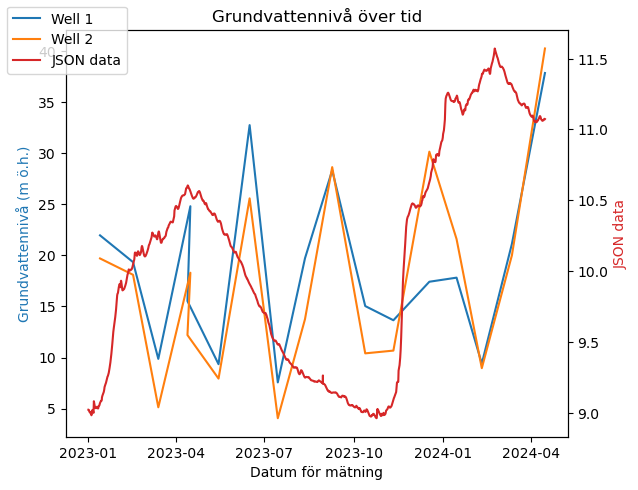

In [1]:
# import necessary libraries
from urllib.request import urlopen 
import json 
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statistics
import matplotlib.dates as mdates
from tabulate import tabulate

# store the URL in url as parameter for urlopen 
url = "https://resource.sgu.se/oppnadata/grundvatten/api/grundvattennivaer/nivaer/station/1_4?format=json"

# store the response of URL 
response = urlopen(url) 

# storing the JSON response from url in data 
data_json = json.loads(response.read()) 

# Extracting data from the "Mätningar" field
timestamps_json = []
water_levels_json = []
for feature in data_json['features']:
    measurements = feature['properties'].get('Mätningar', [])  # Get measurements, default to empty list if key doesn't exist
    for measurement in measurements:
        datum = measurement.get('datum_for_matning')
        grundvattenniva = measurement.get('grundvattenniva_m_o.h.')
        if datum and grundvattenniva:
            timestamps_json.append(datetime.fromisoformat(datum))
            water_levels_json.append(grundvattenniva)

# Read the Excel file
df = pd.read_excel('measurements.xlsx', parse_dates=True)

# Convert the date column to datetime format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# Convert 'Well 1' and 'Well 2' to string, replace comma with period, and convert to float
df['Well 1'] = df['Well 1'].astype(str).str.replace(',', '.').astype(float)
df['Well 2'] = df['Well 2'].astype(str).str.replace(',', '.').astype(float)

# Create separate lists for the timestamps and water levels of each well
timestamps_well1 = df['date'].tolist()
water_levels_well1 = df['Well 1'].tolist()

timestamps_well2 = df['date'].tolist()
water_levels_well2 = df['Well 2'].tolist()

# Define the start and end dates for the time frame you want to plot
start_date = datetime(2023, 1, 1)
end_date = datetime(2024, 12, 31)

# Filter the data based on the selected time frame
timestamps_json, water_levels_json = zip(*[(t, wl) for t, wl in zip(timestamps_json, water_levels_json) if start_date <= t <= end_date])
timestamps_well1, water_levels_well1 = zip(*[(t, wl) for t, wl in zip(timestamps_well1, water_levels_well1) if start_date <= t <= end_date])
timestamps_well2, water_levels_well2 = zip(*[(t, wl) for t, wl in zip(timestamps_well2, water_levels_well2) if start_date <= t <= end_date])

# Calculate statistics
def calculate_statistics(data):
    min_val = np.min(data)
    max_val = np.max(data)
    mean_val = np.mean(data)
    amplitude = max_val - min_val
    median_val = np.median(data)
    std_dev = np.std(data)
    return min_val, max_val, mean_val, amplitude, median_val, std_dev

min_json, max_json, mean_json, amp_json, median_json, std_dev_json = calculate_statistics(water_levels_json)
min_well1, max_well1, mean_well1, amp_well1, median_well1, std_dev_well1 = calculate_statistics(water_levels_well1)
min_well2, max_well2, mean_well2, amp_well2, median_well2, std_dev_well2 = calculate_statistics(water_levels_well2)

# Print the statistics in a table
table = [["JSON data", min_json, max_json, mean_json, median_json, amp_json],
          ["Well 1", min_well1, max_well1, mean_well1, median_well1, amp_well1],
          ["Well 2", min_well2, max_well2, mean_well2, median_well2, amp_well2]]
print(tabulate(table, headers=["Name", "Min", "Max", "Mean", "Median", "Amplitude"]))

# Plotting the data
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Datum för mätning')
ax1.set_ylabel('Grundvattennivå (m ö.h.)', color=color)
line1, = ax1.plot(timestamps_well1, water_levels_well1, color=color)
line2, = ax1.plot(timestamps_well2, water_levels_well2, color='tab:orange')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('JSON data', color=color)  # we already handled the x-label with ax1
line3, = ax2.plot(timestamps_json, water_levels_json, color=color)

# Format the x-axis to display ticks every quarter
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Create a single legend for all lines
fig.legend([line1, line2, line3], ['Well 1', 'Well 2', 'JSON data'], loc='upper left')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Grundvattennivå över tid')
plt.xticks(rotation=45)
plt.show()


**Display correlation between measurements**

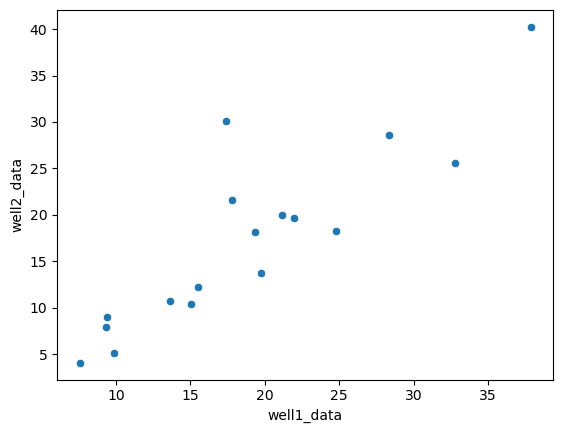

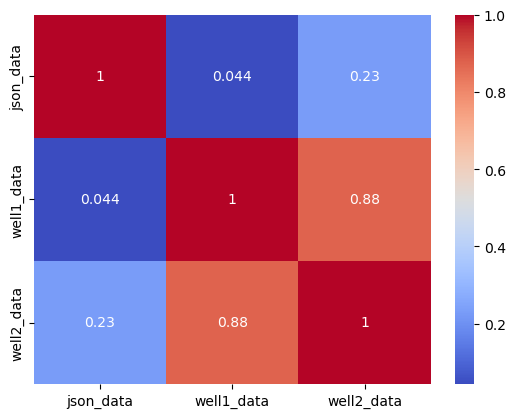

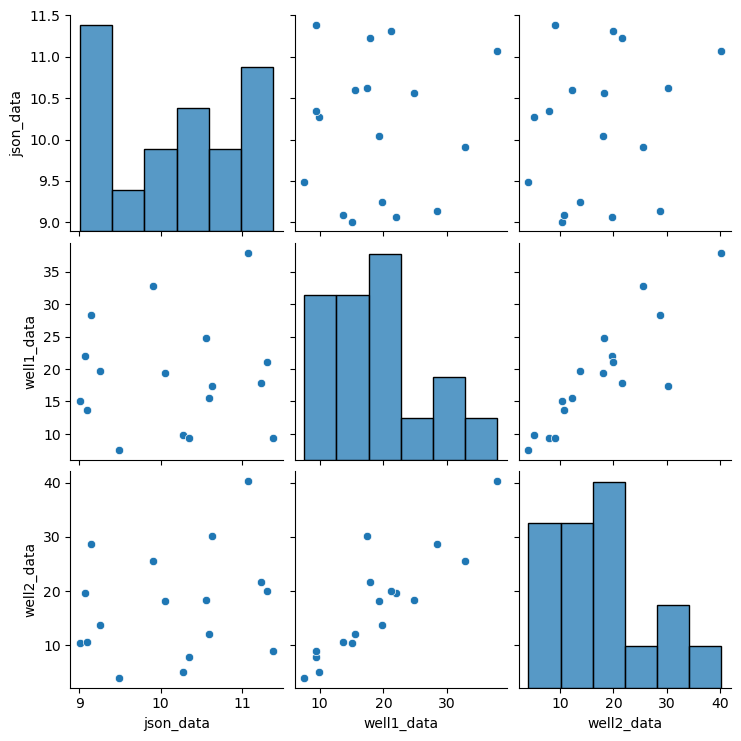

In [3]:
import seaborn as sns

# Convert lists to pandas DataFrame
df_json = pd.DataFrame({
    'timestamps': list(timestamps_json),
    'json_data': list(water_levels_json)
})

df_well1 = pd.DataFrame({
    'timestamps': list(timestamps_well1),
    'well1_data': list(water_levels_well1)
})

df_well2 = pd.DataFrame({
    'timestamps': list(timestamps_well2),
    'well2_data': list(water_levels_well2)
})

# Merge the dataframes on the timestamps
df = pd.merge(df_json, df_well1, on='timestamps', how='inner')
df = pd.merge(df, df_well2, on='timestamps', how='inner')

# Scatter plot
sns.scatterplot(data=df, x='well1_data', y='well2_data')
plt.show()


# Heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# Pairplot
sns.pairplot(df.dropna())
plt.show()
